# Market Shock Recovery Patterns: Statistical Analysis of S&P 500 Stock Reactions

----

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
import yfinance as yf
import pandas as pd

#### Table of Contents 

1. [Introduction](#1-introduction)
2. [Theoretical Framework & Methodology](#2-theoretical-framework--methodology)
3. [Data Collection & Preparation](#3-data-collection--preparation)
4. [Identifying Crashes](#4-identifying-crashes)
5. [Measuring Stock Responses](#5-measuring-stock-responses)
6. [Clustering](#clustering)

## 1. Introduction

This project aims to analyze and understand potential abnormal reactions of the S&P 500 stock market shocks from 2015 to 2025. Specifically, it tests whether large market crashes are followed by **statistically significant** positive returns consistent with return reversals or investor overreaction (De Bondt and Thaler, 1995). For the investor, this translates to whether they can profit by buying stocks right after a their values crash. 

The COVID-19 crash of March 2020 caused a 34% fall on the S&P 500 in just 23 days, yet stocks recovered most losses within weeks. By the end of 2020, the market was significantly higher than its initial value before the pandemic. More recently, Trump's *Liberation Day* led to losses amounting to over 10% of the S&P 500 companies, followed by a full recovery a month later. 

Understanding post-shock returns is crucial for many reasons:
- Investors deciding whether to buy during market panic
- Risk managers assessing portfolio behavior during stress periods
- Academics testing market efficiency (EMH)



## 2. Theoretical Framework & Methodology

### Market Crash

A market crash is an unusually large single-day S&P 500 decline. It is calculated based on the close-to-close return from day $t-1$ to day $t$. Similarly for individual stocks, a large negative shock is a sudden drop in price. Although such declines are often characterized by fixed thresholds, like losses of 3-5% or more, these absolute values may not show the same relevance across firms. Since companies have different characteristics, like volatility, the use of a relative measure is better suited to our objective.


To illustrate the flaw in using absolute thresholds, let's briefly look at market shocks for two companies: Apple and Tesla.

In [3]:
apple = yf.download("AAPL", start="2015-01-01", end="2025-12-31")
tesla = yf.download("TSLA", start="2015-01-01", end="2025-12-31")
threshold = -0.05

apple["Daily Return"] = apple["Close"].pct_change()
tesla["Daily Return"] = tesla["Close"].pct_change()

apple_crash_days = apple[apple["Daily Return"] <= threshold]
tesla_crash_days = tesla[tesla["Daily Return"] <= threshold]

print(f"Number of \"crash\" days for Apple: {len(apple_crash_days)}")
print(f"Number of \"crash\" days for Tesla: {len(tesla_crash_days)}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Number of "crash" days for Apple: 24
Number of "crash" days for Tesla: 161


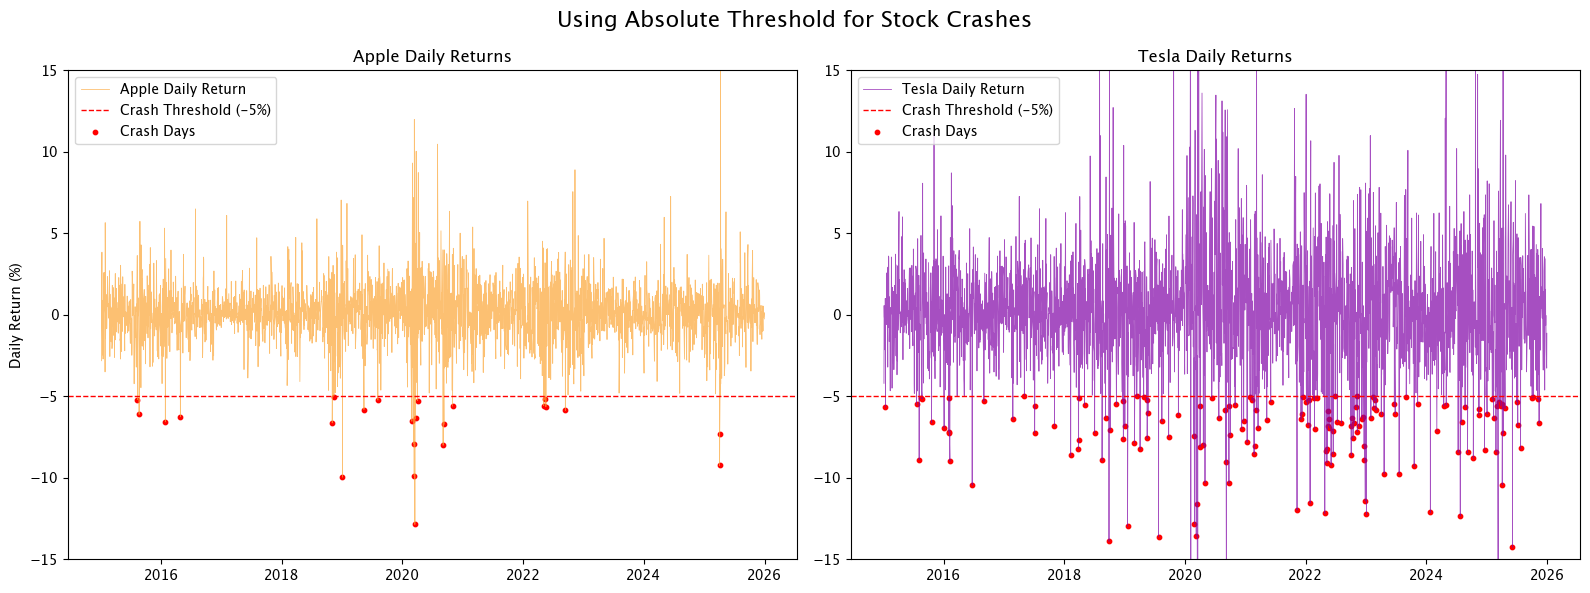

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

y_min = -15
y_max = 15

# Apple
ax1.plot(apple.index, apple["Daily Return"]*100, label="Apple Daily Return", linewidth=0.6, color=cm.plasma(0.8), alpha=0.7)
ax1.axhline(y=-5, color="red", linestyle="--", linewidth=1, label="Crash Threshold (-5%)")
ax1.scatter(apple_crash_days.index, apple_crash_days["Daily Return"]*100, color="red", s=10,label="Crash Days")
ax1.set_title("Apple Daily Returns")
ax1.set_ylabel("Daily Return (%)")
ax1.set_ylim(y_min, y_max)
ax1.legend()

# Tesla
ax2.plot(tesla.index, tesla["Daily Return"]*100, label="Tesla Daily Return", linewidth=0.6, color=cm.plasma(0.26), alpha=0.7)
ax2.axhline(y=-5, color="red", linestyle="--", linewidth=1, label="Crash Threshold (-5%)")
ax2.scatter(tesla_crash_days.index, tesla_crash_days["Daily Return"]*100, color="red", s=10, label="Crash Days")                
ax2.set_title("Tesla Daily Returns")
ax2.set_ylim(y_min, y_max) 
ax2.legend(loc="upper left")


plt.suptitle("Using Absolute Threshold for Stock Crashes", fontsize=16)
plt.tight_layout()
plt.show()

Using the same 5% threshold yields vastly different results for both companies. Under this definition, Apple would experience roughly 7 times less "crashes" than Tesla. But since Tesla's volatility is significantly higher, such comparison is misleading. The same percentage decline may represent a routine fluctuation for a high-volatility stock but an extreme event for a more stable firm.

Instead, we may adopt a more comprehensive measure by defining a crash as a day on which the return decreases below the **mean daily return minus two standard deviations**. By noting $r_t$ the daily return, $\mu$ the mean daily return from 2015 to 2025 and $\sigma$ the corresponding standard deviation, we may formalize a market crash or shock as a day when: 

$$r_t< \mu - 2\sigma$$

Under the assumption that returns are *approximately* normally distributed, about 95% of observations lie within two standard deviations of the mean. Consequently, a return below $\mu - 2\sigma$ corresponds to roughly the lowest 2.5% of outcomes, which translates to statistically rare negative movements. 

### Abnormal Returns

To determine if a stock's recovery is *exceptional*, we first need to determine what "normal" recovery looks like. We use the concept of **abnormal returns**:

$$\text{Abnormal Return} = \text{Actual Return} - \text{Expected Return}$$
$$\text{i.e.  } AR_n = R_{\text{actual},n} - E[R_n]$$

The **actual return** is the cumulative return from the crash date through the measurement window. As we will see later, the selected $n$ timeframe will be 1, 5, 10 and 20 days. 

$$R_{\text{actual}} = \frac{\text{Price at the end of window}}{\text{Price on crash day}}-1$$

The **expected return** is the stock's average daily return on normal trading days (days without crash). This baseline captures how the stock typically behaves under norma market conditions.

$$E[R] = \text{mean daily return on non-crash days}$$

This is calculated from all non-crash days in the period and represents the stock's typical daily return. But for abnormal return analysis, we need to scale it to match the timeframe of $n$ days, which is:

$$E[R_n] = E[R] \times n$$

If a stock rebounds more than expected (positive abnormal return), it outperformed its historical pattern. Conversely, if it rebounds less (negative abnormal return), it underperformed.

Thus the abnormal return is simply the difference between what actually happened and what we would expect based on the stock's normal behavior:

- **Positive abnormal return**: Stock rebounded better than its typical (expected) behavior, which suggests a recovery effect
- **Negative abnormal return**: Stock rebounded worse than its typical behavior
- **Zero abnormal return**: Stock followed its normal pattern

### Data & Sample

We analyze data from of the S&P 500 from January 01, 2015 through December 31, 2025. We use two datasets: 

- The [yfinance](https://ranaroussi.github.io/yfinance/) python library to retrieve financial data (Opening Price, Closing Price, Highest Price, Lowest Price & Volume).
- The [S&P 500 Constituents](https://github.com/datasets/s-and-p-500-companies/tree/main) dataset which provides basic information for each company (Sector, Industry, Location, Year Founded, etc..).

We employ stratified random sampling to select 50 large-cap S&P 500 stocks. We stratify the index by GICS sector (11 sectors), then randomly sample from each sector proportionally. This ensures representation from all sectors and randomness.



## 3. Data Collection & Preparation 

In [5]:
# Config
start_date = "2015-01-01"
end_date = "2025-12-31"

df = pd.read_csv("dataset/constituents.csv")
df.columns

Index(['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date added', 'CIK', 'Founded'],
      dtype='str')

### S&P 500 Companies by Sector

GICS Sector
Energy                     4.37%
Communication Services     4.77%
Materials                  5.17%
Utilities                  6.16%
Real Estate                6.16%
Consumer Staples           7.55%
Consumer Discretionary    10.14%
Health Care               11.93%
Information Technology    13.52%
Financials                14.71%
Industrials               15.51%
Name: count, dtype: str


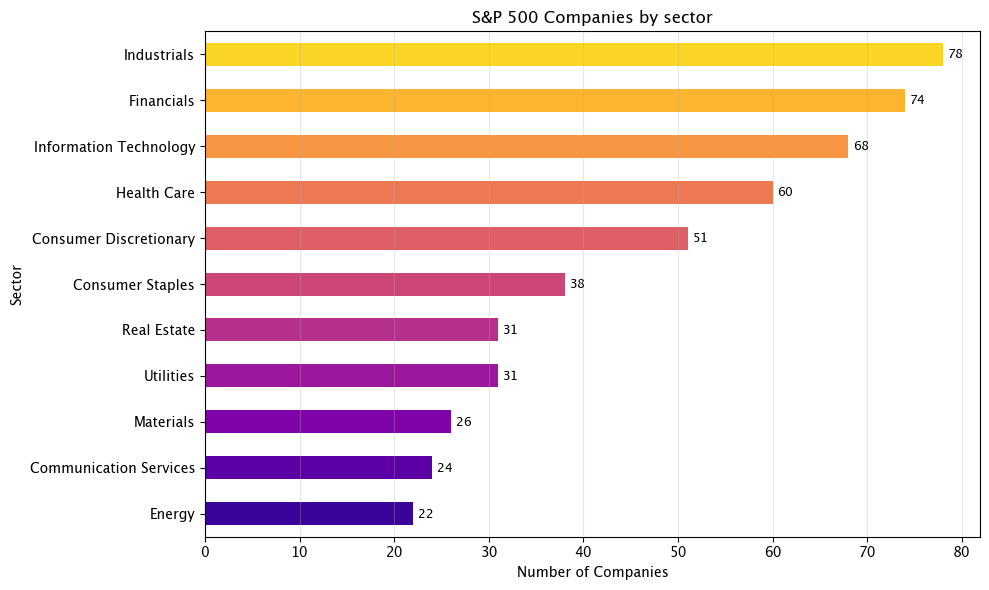

In [6]:
sector_counts = df["GICS Sector"].value_counts().sort_values()
sector_proportion = sector_counts / sector_counts.sum()

print((sector_proportion*100).round(2).astype(str) + "%")

ax3 = sector_counts.plot(kind="barh", figsize=(10,6), color=sns.color_palette("plasma", len(sector_counts)), title="S&P 500 Companies by sector")
ax3.grid(axis="x", alpha=0.3)

ax3.set_xlabel("Number of Companies")
ax3.set_ylabel("Sector")

for index, value in enumerate(sector_counts):
    ax3.text(value + 0.5, index, str(value), va="center", fontsize=9)

plt.tight_layout()
plt.show()

### Stratified Sampling

We sample 50 companies (or 10%) of the S&P 500 with a representative proportion in each sector. Below is the number of companies required per sector.

In [7]:
sample_size = 50
samples_per_sector = (df["GICS Sector"].value_counts(normalize=True) * sample_size).round().astype(int)
print(samples_per_sector)

GICS Sector
Industrials               8
Financials                7
Information Technology    7
Health Care               6
Consumer Discretionary    5
Consumer Staples          4
Utilities                 3
Real Estate               3
Materials                 3
Communication Services    2
Energy                    2
Name: proportion, dtype: int64


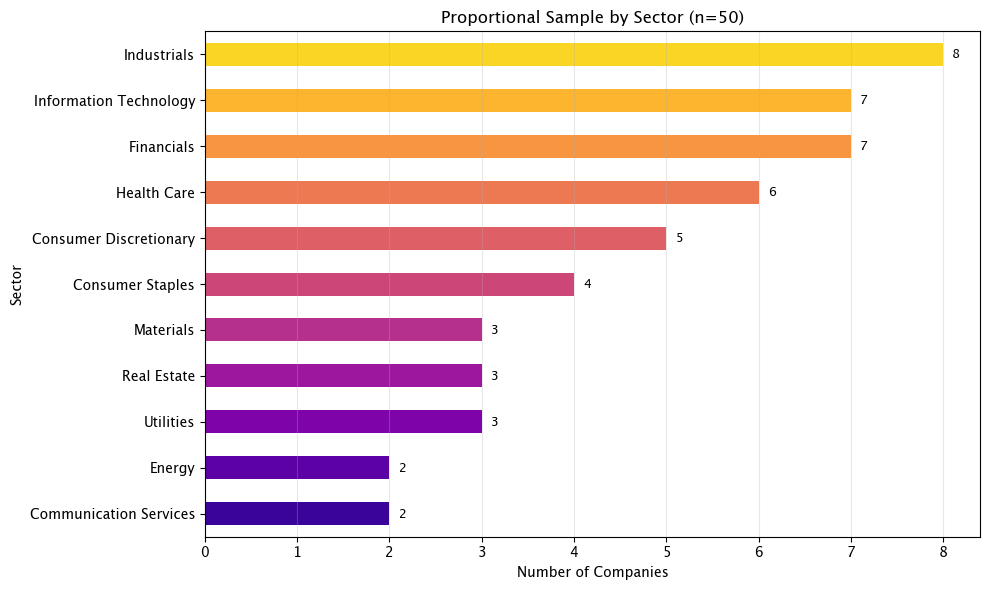

In [8]:
ax4 = samples_per_sector.sort_values().plot(kind="barh", figsize=(10, 6), color=sns.color_palette("plasma", len(samples_per_sector)), title="Proportional Sample by Sector (n=50)")

ax4.grid(axis="x", alpha=0.3)
ax4.set_xlabel("Number of Companies")
ax4.set_ylabel("Sector")

for index,value in enumerate(samples_per_sector.sort_values()):
    ax4.text(value +0.1, index, str(value), va="center", fontsize=9)


plt.tight_layout()
plt.show()

Using stratified sampling, we obtain the following 50 companies.

In [9]:
final_sample = pd.DataFrame()

df_remaining = df[["Symbol", "GICS Sector"]].copy() # in order to avoid duplicate
samples_per_sector = (df["GICS Sector"].value_counts(normalize=True) * sample_size).round().astype(int)

randomstate = 666

# Looping through each sector and sampling the required number for each

for sector in set(df["GICS Sector"]):
    required_number = samples_per_sector.get(sector, 0)

    sampled_rows = df[df["GICS Sector"] == sector].sample(n=required_number, random_state=randomstate)

    final_sample = pd.concat([final_sample, sampled_rows], ignore_index=True)

df_remaining = df_remaining[~df_remaining["Symbol"].isin(final_sample["Symbol"])] # remove the obtained 50 companies from the dataframe

# Verification: ensure if each stock has valid data in the yfinance dataset 
for stock in final_sample["Symbol"]:
    data = yf.download(stock, start=start_date, end=end_date, progress=False)

    # If a company lacks data, change it
    if data.empty or data.isna().any().any():
        sector = final_sample[final_sample["Symbol"] == stock]["GICS Sector"].values[0]
        replacement = df_remaining[df_remaining["GICS Sector"] == sector].iloc[0]["Symbol"]

        final_sample.loc[final_sample["Symbol"] == stock, "Symbol"] = replacement
        df_remaining = df_remaining[df_remaining["Symbol"] != replacement]
        
        # Tell which stock were replaced by which one
        print(f"Replaced {stock} with {replacement} ({sector})")

final_sample

HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: FI"}}}
$FI: possibly delisted; no timezone found

1 Failed download:
['FI']: possibly delisted; no timezone found


Replaced FI with AFL (Financials)


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MOS,Mosaic Company (The),Materials,Fertilizers & Agricultural Chemicals,"Tampa, Florida",2011-09-26,1285785,2004 (1865 / 1909)
1,FCX,Freeport-McMoRan,Materials,Copper,"Phoenix, Arizona",2011-07-01,831259,1912
2,SW,Smurfit Westrock,Materials,Paper & Plastic Packaging Products & Materials,"Dublin, Ireland",2024-07-08,2005951,1934
3,LHX,L3Harris,Industrials,Aerospace & Defense,"Melbourne, Florida",2008-09-22,202058,"2019 (L3 1997, Harris 1895)"
4,LDOS,Leidos,Industrials,Diversified Support Services,"Reston, Virginia",2019-08-09,1336920,1969
5,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
6,HII,Huntington Ingalls Industries,Industrials,Aerospace & Defense,"Newport News, Virginia",2018-01-03,1501585,2011
7,EMR,Emerson Electric,Industrials,Electrical Components & Equipment,"Ferguson, Missouri",1965-03-31,32604,1890
8,GWW,W. W. Grainger,Industrials,Industrial Machinery & Supplies & Components,"Lake Forest, Illinois",1981-06-30,277135,1927
9,AME,Ametek,Industrials,Electrical Components & Equipment,"Berwyn, Pennsylvania",2013-09-23,1037868,1930


![Stratified Sample](figures/sampled-companies.png)

## 4. Identifying Crashes


In [10]:
sp500 = yf.download("^GSPC", start=start_date, end=end_date) # ^GSPC refers to the S&P 500 index
sp500

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000
...,...,...,...,...,...
2025-12-23,6909.790039,6910.879883,6868.810059,6872.410156,3820560000
2025-12-24,6932.049805,6937.319824,6904.910156,6904.910156,1798270000


### How Many S&P 500 Crashes Since 2015?

In [11]:
sp500["Daily Return"] = sp500["Close"].pct_change()
mean = sp500["Daily Return"].mean()
std = sp500["Daily Return"].std()
crash_threshold = mean - 2 * std

# Crash days
crash_days = sp500[sp500["Daily Return"] < crash_threshold]
number_of_crashes = len(crash_days)

print(f"- Mean daily return: {(mean*100).round(3)}%")
print(f"- Standard deviation of daily returns: {(std*100).round(3)}%")
print(f"- Crash threshold: {(crash_threshold*100).round(3)}%")
print(f"- Number of days the S&P 500 fell below this threshold: {number_of_crashes}")

print("\nDates of these crashes and their returns:")
print((crash_days["Daily Return"] * 100).round(3).astype(str) + "%")

- Mean daily return: 0.05%
- Standard deviation of daily returns: 1.128%
- Crash threshold: -2.207%
- Number of days the S&P 500 fell below this threshold: 76

Dates of these crashes and their returns:
Date
2015-08-21    -3.185%
2015-08-24    -3.941%
2015-09-01    -2.958%
2015-09-28    -2.567%
2016-01-07     -2.37%
               ...   
2025-04-04    -5.975%
2025-04-10    -3.461%
2025-04-16    -2.241%
2025-04-21    -2.357%
2025-10-10    -2.711%
Name: Daily Return, Length: 76, dtype: str


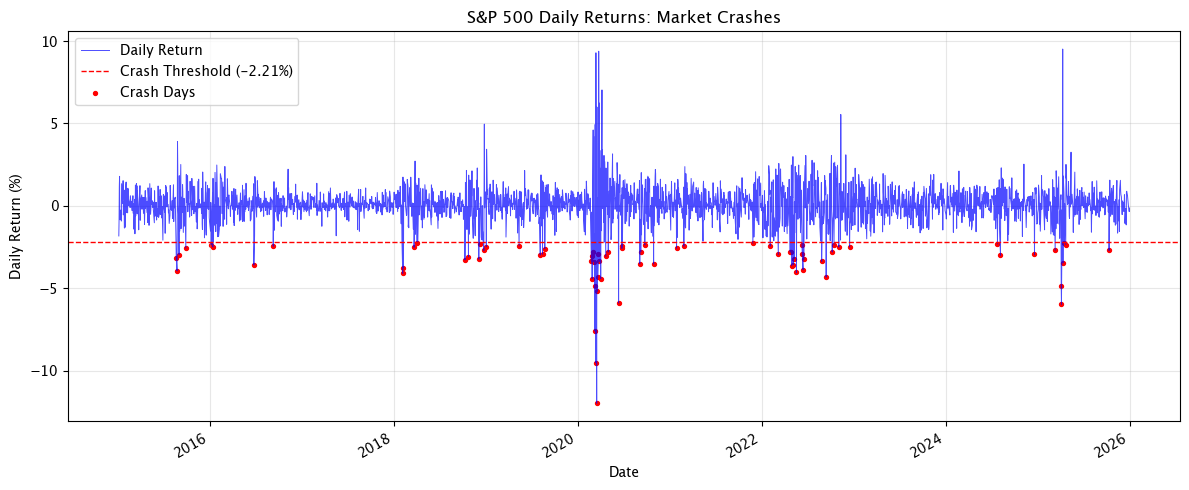

In [12]:
ax4 = (sp500["Daily Return"] * 100).plot(figsize=(12, 5),color="blue", linewidth=0.7, alpha=0.7, title="S&P 500 Daily Returns: Market Crashes", ylabel="Daily Return (%)", xlabel="Date", grid=True)
ax4.axhline(y=crash_threshold *100,color="red", linestyle="--", linewidth=1, label=f"Crash Threshold ({(crash_threshold*100).round(2)}%)")
ax4.scatter(crash_days.index, crash_days["Daily Return"] *100, color="red", s=8,label="Crash Days")
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Since we are mainly interested in *individual stock crashes*, we will focus on them.

### Stock Crashes

In [13]:
stocks = yf.download(final_sample["Symbol"].tolist(), start=start_date, end=end_date)
stocks.head()

[*********************100%***********************]  50 of 50 completed


Price           Close                                                        \
Ticker            AFL        AIG        ALL        AME      ANET        AOS   
Date                                                                          
2015-01-02  23.552130  43.088268  55.219749  48.871128  3.917500  23.357471   
2015-01-05  22.935177  42.235867  54.125092  47.403687  3.987500  22.948792   
2015-01-06  22.730818  41.636898  54.085724  46.493526  3.988125  22.761135   
2015-01-07  22.873487  41.836544  54.975601  46.632832  4.071250  22.927942   
2015-01-08  23.097132  41.652237  56.030861  47.784477  4.132500  23.524286   

Price                                               ... Volume            \
Ticker             AZO         BG        BIIB CARR  ...   PYPL      SBUX   
Date                                                ...                    
2015-01-02  616.789978  66.203842  342.010010  NaN  ...    NaN   6886000   
2015-01-05  608.489990  64.860275  336.739990  NaN  ...    NaN  11623800   
2015-01-06  607.820007  64.250267  334.649994  NaN  ...    NaN   7664400   
2015-01-07  607.239990  64.584312  353.239990  NaN  ...    NaN   9732600   
2015-01-08  606.000000  65.768082  350.250000  NaN  ...    NaN  13170600   

Price                                                                           
Ticker         SMCI       SO   SW     SWKS      TAP     TRGP      VTR     WYNN  
Date                                                                            
2015-01-02  2073000  4645300    0  2850200   811100   471200  1740366  2228900  
2015-01-05  3900000  7028700    0  2924500  1288400   956000  2447932  1695100  
2015-01-06  3381000  9358300    0  4746300  1358800  1072700  3771815  1975800  
2015-01-07  3553000  4917000  500  2896200  1507700   745000  2613176  1472000  
2015-01-08  3599000  4532500    0  3773000  1810700   833000  3219161  1676600  

[5 rows x 250 columns]

#### Computing Crash Thresholds

For each of the 50 sampled stocks, let's compute the crash threshold $\mu - 2\sigma$. We will use the existing `final_sample` dataframe to create a new one that will hold the threshold value for each stock. We will use the `yfinance` library to retrieve data from each stock.

In [14]:
stocks_info = final_sample[["Symbol", "Security", "GICS Sector", "GICS Sub-Industry", "Founded"]].copy()

symbols = stocks_info["Symbol"].tolist()

stocks_info["Crash Threshold"] = 0.0

# For each stock, compute mean, std, and find threshold
for symbol in symbols:

    mean = stocks["Close"][symbol].pct_change().mean()
    std = stocks["Close"][symbol].pct_change().std()

    stocks_info.loc[stocks_info["Symbol"] == symbol, "Crash Threshold"] = mean - 2*std

stocks_info["Crash Threshold %"] = (stocks_info["Crash Threshold"] * 100).round(2)

stocks_info[["Symbol", "Security", "GICS Sector", "Crash Threshold", "Crash Threshold %"]].head(25)
    

,Symbol,Security,GICS Sector,Crash Threshold,Crash Threshold %
0,MOS,Mosaic Company (The),Materials,-0.055120,-5.51
1,FCX,Freeport-McMoRan,Materials,-0.067304,-6.73
2,SW,Smurfit Westrock,Materials,-0.051338,-5.13
3,LHX,L3Harris,Industrials,-0.030897,-3.09
4,LDOS,Leidos,Industrials,-0.033507,-3.35
5,AOS,A. O. Smith,Industrials,-0.033441,-3.34
6,HII,Huntington Ingalls Industries,Industrials,-0.036590,-3.66
7,EMR,Emerson Electric,Industrials,-0.034704,-3.47
8,GWW,W. W. Grainger,Industrials,-0.034304,-3.43
9,AME,Ametek,Industrials,-0.029626,-2.96


### Detecting the Crashes

Now let's detect how many times each of the 50 stock crashed.  

In [15]:
stocks_info["Crashed"] = 0

for symbol in symbols:
    # Find all the days where the daily return is less than the crash threshold
    crash_days = stocks["Close"][symbol].pct_change() <= stocks_info[stocks_info["Symbol"] == symbol]["Crash Threshold"].values[0]

    stocks_info.loc[stocks_info["Symbol"] == symbol, "Crashed"] = crash_days.sum()


stocks_info[["Symbol", "Security", "Crash Threshold %", "Crashed"]].head(25)

,Symbol,Security,Crash Threshold %,Crashed
0,MOS,Mosaic Company (The),-5.51,72
1,FCX,Freeport-McMoRan,-6.73,65
2,SW,Smurfit Westrock,-5.13,86
3,LHX,L3Harris,-3.09,67
4,LDOS,Leidos,-3.35,60
5,AOS,A. O. Smith,-3.34,82
6,HII,Huntington Ingalls Industries,-3.66,66
7,EMR,Emerson Electric,-3.47,61
8,GWW,W. W. Grainger,-3.43,54
9,AME,Ametek,-2.96,58


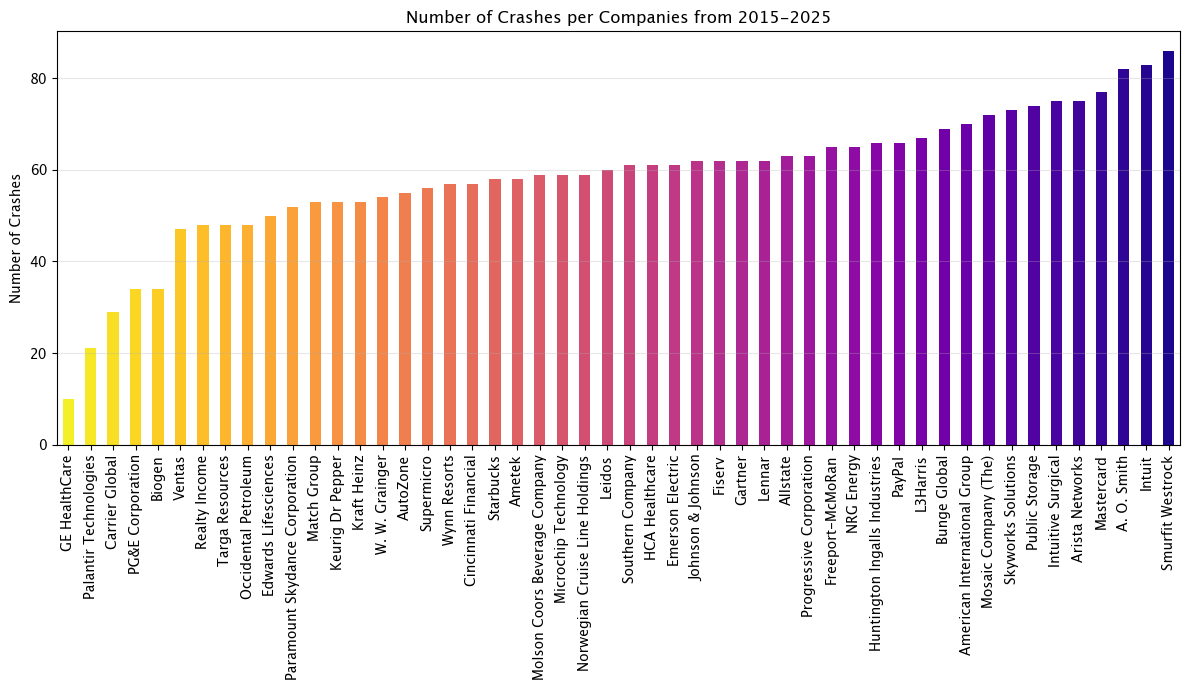

In [16]:
ax4 = stocks_info.sort_values(by="Crashed").plot(kind="bar", x="Security", y="Crashed", figsize=(12,7), color=sns.color_palette("plasma_r", len(stocks_info)), title="Number of Crashes per Companies from 2015-2025", legend=False)

ax4.set_xlabel("")
ax4.set_ylabel("Number of Crashes")
ax4.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

From the results above, we find that most stocks crashed about 50-70 times over a 10-year period. It represents a small proportion of days, coherent with the rarity of a crash.

## 5. Measuring Stock Responses

### Crash Dates 



### Computing Daily Expected Returns

The expected return $E[R]$ is the mean daily returns of the stock for each day except on crash days. For each company, let's compute their respective expected return from 2015 to 2025.


In [ ]:
stocks_info["Expected Return"] = 0.0

for symbol in symbols:

    returns = stocks["Close"][symbol].pct_change()
    
    threshold = stocks_info[stocks_info["Symbol"] == symbol]["Crash Threshold"].values[0]

    # Filter non-crash days
    non_crash_returns = returns[returns > threshold]
    
    expected_return = non_crash_returns.mean() * 100

    stocks_info.loc[stocks_info["Symbol"] == symbol, "Expected Return"] = expected_return.round(3)

stocks_info[["Symbol", "Security", "Crash Threshold %", "Crashed", "Expected Return"]].head(25)

,Symbol,Security,Crash Threshold %,Crashed,Expected Return
0,MOS,Mosaic Company (The),-5.51,72,0.234
1,FCX,Freeport-McMoRan,-6.73,65,0.327
2,SW,Smurfit Westrock,-5.13,86,0.327
3,LHX,L3Harris,-3.09,67,0.186
4,LDOS,Leidos,-3.35,60,0.212
5,AOS,A. O. Smith,-3.34,82,0.191
6,HII,Huntington Ingalls Industries,-3.66,66,0.210
7,EMR,Emerson Electric,-3.47,61,0.175
8,GWW,W. W. Grainger,-3.43,54,0.179
9,AME,Ametek,-2.96,58,0.167


So on average, non-crash days historically returned +0.23% for the Mosaic Company, +0.33% for Freeport-McMoran, etc...